In [1]:
import numpy as np
from torch.optim import Adam
from pytorch_shared import *
import torch
import torch.nn as nn
import gym
import time
import pybullet
import reach2D
import os
import pointMass
from SAC import *
from HER import *
from BC import * 
from common import *
from tensorboardX import SummaryWriter
from gym import wrappers
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt

PLAY = True

current_dir=/home/sholto/Desktop/AI/rl_transformers/adv_weighted_play


In [2]:
env_name = 'pointMassObject-v0'
data = np.load('collected_data/17100experiment_2_HER_pointMassObject-v0.npz')

ac_kwargs = dict(hidden_sizes=[128]*2)
seed = 0
replay_size = int(1e6)
lr = 3e-4
load = False
exp_name = 'AWAC'
render = True
strategy = 'final'
batch_size = 200


env, test_env, act_limit, obs_dim, act_dim, summary_writer = setup(env_name, ac_kwargs, seed, replay_size, lr, load, exp_name, render, strategy)


seeding
Environment set to sparse reward
seeding
Environment set to sparse reward
Rendering Test Rollouts


/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:

train_partition = 0.8
N_TRAJS = len(data['obs'])
TRAJ_LEN = len(data['obs'][0])
train_data = {key:value[:int(N_TRAJS*train_partition)] for key, value in data.items()}
valid_data = {key:value[int(N_TRAJS*train_partition):] for key, value in data.items()}

In [4]:
# data_r_buf_format


replay_buffer = HERReplayBuffer(env, obs_dim, act_dim, replay_size, n_sampled_goal=4,
                                goal_selection_strategy=strategy)

model = SAC_model(act_limit, obs_dim, act_dim, ac_kwargs['hidden_sizes'], lr, load=load, exp_name=exp_name,
                  replay_buffer=replay_buffer)


episodes = data_to_r_buf_episodes(train_data, env)
_ = [replay_buffer.store_hindsight_episode(e) for e in episodes]
           
batch_size = 200

qs = []
pis = []
steps = []

False -------------------

Number of parameters: 	 pi: 18436, 	 q1: 18305, 	 q2: 18305



In [5]:


for i in tqdm(range(0, 1000)):
    batch = replay_buffer.sample_batch()
    loss_q, loss_pi = model.update(batch)
    qs.append(loss_q)
    pis.append(loss_pi)
    steps.append(i)

100%|██████████| 1000/1000 [00:11<00:00, 89.39it/s]


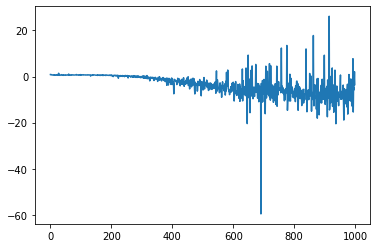

In [6]:
plt.plot(steps, qs)


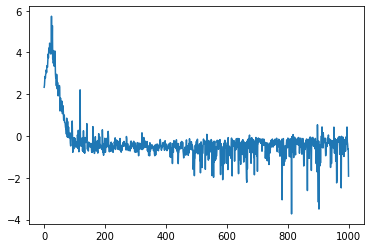

In [7]:
plt.plot(steps, pis)

In [16]:
def trajectory(env, actor, n_steps = 300):
    obs = env.reset()
    reward = 0
    for t in range(0, n_steps):
        flattened_obs  = np.expand_dims(np.concatenate((obs['observation'], obs['desired_goal'])), axis = 0)
        a = actor(flattened_obs).squeeze()
        obs, r, d, _  =  env.step(a)
        reward += r
    return reward

trajectory(test_env, model.actor.get_deterministic_action)

-300.0

In [23]:
def plot_heatmap(X,Y,Z):
    mesh = plt.pcolormesh(X,Y,Z)
    cb = plt.colorbar()
    plt.scatter(o[0], o[1], marker = 'x')
    plt.scatter(o[-2], o[-1])
    arr = mesh.get_array().reshape(mesh._meshWidth, mesh._meshHeight)
    plt.imshow(arr.T, origin = 'lower', extent = [0, size, 0, size], alpha=0.8)
    plt.show()
    

# simple for when using achieved goal with a single achieved goal in pm or pmO
def heatmap_q(model, o, size, relative = True):
    a  =np.linspace(-env.ENVIRONMENT_BOUNDS,env.ENVIRONMENT_BOUNDS,80)
    r = []
    for i in  list(a):
        for j in  list(a):
            r.append([i,j])
    tiled_os  = np.tile(np.expand_dims(o,0),[len(r),1])
    options = np.array(r)
    
    print(options.shape)
    if relative:
        options = options - tiled_os[:,0:2]
    
    print(tiled_os.shape)
    tiled_os = torch.as_tensor(tiled_os, dtype=torch.float32).cuda()
    options = torch.as_tensor(options, dtype=torch.float32).cuda()
    q_vals = model.ac.q1(tiled_os, options).cpu().detach().numpy()

    if relative:
        options = options + tiled_os[:,0:2]
                  
    options = (options).cpu().detach().numpy()
    X = options[:,0].reshape(len(a),len(a))  #(np.meshgrid(a,a)
    Y = options[:,1].reshape(len(a),len(a))
    #X, Y = np.meshgrid(a,a)

    Z=q_vals.reshape(len(a),len(a))
    plot_heatmap(X,Y,Z)

(6400, 2)
(6400, 10)


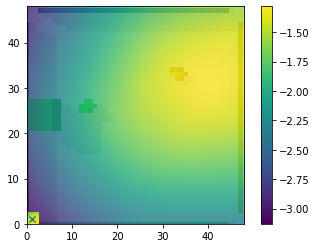

In [24]:
obs = test_env.reset()
o  = np.concatenate((obs['observation'], obs['desired_goal']))
image = test_env.calc_state()['image']
size = image.shape[0]
plt.imshow(np.flip(image,0), origin = 'lower')
heatmap_q(model, o, size)